In [2]:
pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=814e7ff48672a795fa5a3a8fc69d927f79a4a2e5a927809b7093682540044c73
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


In [3]:
pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 7.3 MB/s eta 0:00:00


In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import re
from textblob import TextBlob as tb
from autocorrect import Speller as sp
import emoji
import nltk
from nltk.tokenize import word_tokenize as wt,sent_tokenize as st
from nltk.corpus import stopwords
from nltk import PorterStemmer,LancasterStemmer,SnowballStemmer
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import FunctionTransformer,PowerTransformer

from sklearn.pipeline import Pipeline,make_pipeline

import pickle

from sklearn.naive_bayes import MultinomialNB

In [5]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### 1.Problem Statement
Create a model for predicting wheather text have spam or ham

### 2.Data Collection

In [7]:
# collect dataset from kaggle
data = pd.read_csv(r"/content/drive/MyDrive/Spam detection/spam.csv",encoding="latin-1",usecols = ["v1","v2"])
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### 3.EDA before text pre-processing

In [8]:
data.shape # data contains 5572 rows and 2 columns

(5572, 2)

In [9]:
data.info()   # both columns are object only

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [10]:
data.isnull().sum()   # both columns are doesn't contain null values

v1    0
v2    0
dtype: int64

In [11]:
data.duplicated().sum()    # my data set contains 403 duplicated rows

403

In [12]:
data.drop_duplicates(keep="first",inplace=True)

In [13]:
data.duplicated().sum()     # drop duplicate values

0

In [14]:
data.v1.unique()   # unique values for class label

array(['ham', 'spam'], dtype=object)

In [15]:
data.v1.value_counts() # 4516 rows belongs to  (ham) and 653 rows belongs to (spam)

ham     4516
spam     653
Name: v1, dtype: int64

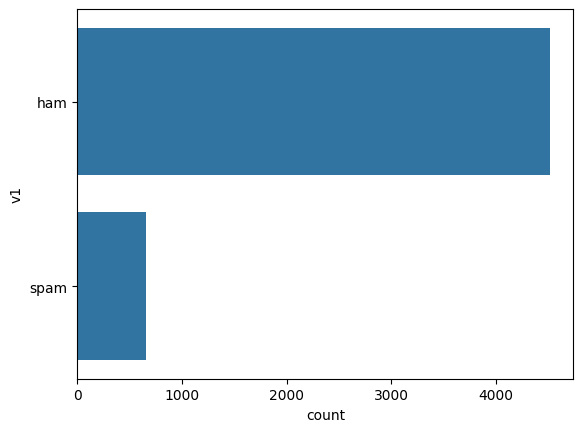

In [18]:
sns.countplot(data.v1)    # this is imbalnced data
plt.show()

In [19]:
fv = data.iloc[:,1]
cv = data.iloc[:,0]

In [20]:
cv = cv.map({"ham":1,"spam":0})     # convert class variables ham as 1 and spam as 0.

In [21]:
x_train,x_test,y_train,y_test = train_test_split(fv,cv,test_size=0.2,stratify=cv)

### 4.Text pre-processing

In [22]:
def lowers(x):
    return x.str.lower()

def html(x):
    return x.apply(lambda x:re.sub("<.+?>"," ",x))

def url(x):
    return x.apply(lambda x:re.sub("https[s]?://.+? +"," ",x))

def unw(x):
    return x.apply(lambda x:re.sub("[]()*\-.:,@#$%&^!?/0-9']"," ",x))

def emoji_remove(x):
    x = x.apply(lambda x : emoji.demojize(x))
    return x

In [23]:
def lemma(x):
  list_stp = stopwords.words("english")  # list_stp contains group of stop words.
  wl=WordNetLemmatizer()

  def lemmatize_text(text):
        words = wt(text)
        lemmatized_words = [wl.lemmatize(word, pos="v") for word in words if word not in list_stp]
        return " ".join(lemmatized_words)

  return x.apply(lemmatize_text)

In [24]:
# create a pipeline for pre-processing the data
pre_pro_pi = Pipeline([("Emoji's", FunctionTransformer(emoji_remove)),("lower",FunctionTransformer(lowers)),("html",FunctionTransformer(html)),
                       ("url",FunctionTransformer(url)),("unw",FunctionTransformer(unw)),("advance",FunctionTransformer(lemma))])

In [25]:
final_pipe = Pipeline([("pre_process",pre_pro_pi),("vectorizer",CountVectorizer())])

In [26]:
pre_pro_pi.fit_transform(x_train)

4728                                        reach already
1499    sms ac jsco energy high u may know channel day...
709     mths half price orange line rental latest came...
1683                           already squat new way walk
3987    hello sort town already dont rush home eat nac...
                              ...                        
4262    den weekdays get special price haiz cant eat l...
2519                     ok ask abt e movie u wan ktv oso
2468             lol well without could big sale together
2627    know lack particular dramastorm detail part worry
1559    single line big mean \miss anything ur \ '' be...
Name: v2, Length: 4135, dtype: object

In [27]:
final_pipe.fit_transform(x_train)

<4135x5913 sparse matrix of type '<class 'numpy.int64'>'
	with 33284 stored elements in Compressed Sparse Row format>

In [28]:
import pickle
pickle.dump(final_pipe,open(r"/content/drive/MyDrive/Spam detection/pre.pkl","wb"))

### EDA after pre-processing
we are perform on text data,so this is totally based on frequency of words or frequency of chracters or most common words based on types of spam or ham

In [34]:
featur_var = pre_pro_pi.fit_transform(x_train)
featur_var = pd.DataFrame(featur_var)
class_var = pd.DataFrame(y_train,columns = ["v1"])

df = pd.concat([featur_var,class_var],axis=1)    # concat fv and data["Target"] as new data frame
df.head()

,v2,v1
4728,reach already,1
1499,sms ac jsco energy high u may know channel day...,0
709,mths half price orange line rental latest came...,0
1683,already squat new way walk,1
3987,hello sort town already dont rush home eat nac...,1


In [35]:
df["v1"] = df["v1"].map({0:"spam",1: "ham"})

In [36]:
# seperate data into Targets.
gp = df.groupby("v1")
ham = gp.get_group("ham")["v2"]
spam = gp.get_group("spam")["v2"]

In [37]:
gp.get_group("ham")["v2"]

4728                                        reach already
1683                           already squat new way walk
3987    hello sort town already dont rush home eat nac...
3446                sit ard nothing lor u leh busy w work
1315    whenevr ur sad whenevr ur gray remembr im list...
                              ...                        
4262    den weekdays get special price haiz cant eat l...
2519                     ok ask abt e movie u wan ktv oso
2468             lol well without could big sale together
2627    know lack particular dramastorm detail part worry
1559    single line big mean \miss anything ur \ '' be...
Name: v2, Length: 3613, dtype: object

In [38]:
# Combine entire rows text into one text
ft = " ".join(gp.get_group("spam")["v2"]).split()
jt = " ".join(gp.get_group("ham")["v2"]).split()


In [39]:
# find how many words contain each emotion
print("spam class contains",len(ft),"number of words")
print("ham class contains",len(jt),"number of words")

spam class contains 8391 number of words
ham class contains 29594 number of words


In [40]:
pip install wordcloud

In [41]:
from collections import Counter
Counter(ft).most_common(10)

[('call', 269),
 ('å£', 197),
 ('free', 170),
 ('u', 121),
 ('p', 121),
 ('txt', 114),
 ('ur', 95),
 ('mobile', 93),
 ('text', 88),
 ('stop', 86)]

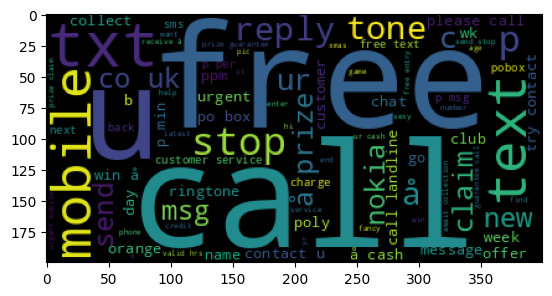

In [42]:
from wordcloud import WordCloud
wc = WordCloud().generate(" ".join(gp.get_group("spam")["v2"]))
plt.imshow(wc)
plt.show()

In [43]:
Counter(jt).most_common(10)

[('u', 741),
 (';', 545),
 ('get', 479),
 ('go', 406),
 ('come', 237),
 ('gt', 231),
 ('lt', 229),
 ('ok', 209),
 ('know', 195),
 ('call', 193)]

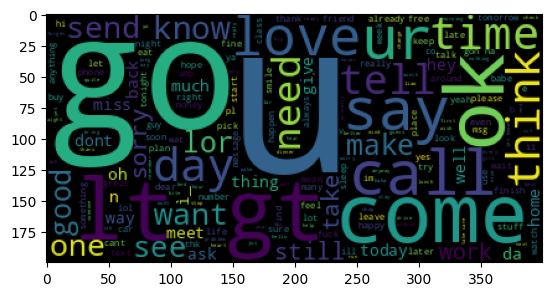

In [44]:
from wordcloud import WordCloud
wc = WordCloud().generate(" ".join(gp.get_group("ham")["v2"]))
plt.imshow(wc)
plt.show()

### 6.feature engineering

In [45]:
final_xtrain = final_pipe.fit_transform(x_train)
final_xtest = final_pipe.transform(x_test)

In [46]:
cv = CountVectorizer()    # it will take CountVectorizer function

### 7.Model training

In [47]:
mb = MultinomialNB()
model = mb.fit(final_xtrain,y_train)

In [48]:
pickle.dump(model,open(r"/content/drive/MyDrive/Spam detection/model.pkl","wb"))

### 8.Model evaluation

In [55]:
from sklearn.metrics import confusion_matrix , classification_report,accuracy_score

In [52]:
print(classification_report(y_test,model.predict(final_xtest)) )   # it will give 97% accuracy to predicting class labels

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       131
           1       0.99      0.99      0.99       903

    accuracy                           0.98      1034
   macro avg       0.97      0.96      0.96      1034
weighted avg       0.98      0.98      0.98      1034



In [54]:
confusion_matrix(y_test,model.predict(final_xtest))

array([[121,  10],
       [  6, 897]])

In [56]:
accuracy_score(y_test,model.predict(final_xtest))

0.9845261121856866

### 9.Testing

In [57]:
m = final_pipe.transform(x_test.iloc[[1]])  # convert text into sprse matrix used by transform() method
pred = model.predict(m)   # it is used to shows that predicted value

if pred == 0:
    print("spam")
else:
    print("ham")

ham


### 10.Conclusion

In conclusion, the development of machine learning models for predicting spam or ham (non-spam) based on textual data represents a critical application in modern information security and communication filtering. Through meticulous data preprocessing, feature engineering, and model selection, researchers and practitioners have achieved remarkable success in accurately classifying incoming messages.

Key to the effectiveness of these models is the careful selection and engineering of features, which often include word frequency, presence of specific keywords, and syntactic or semantic characteristics of the text. Additionally, techniques such as Countvectorizer and word embeddings have proven instrumental in capturing nuanced patterns and semantic relationships within the textual data.